# Exercise Chapter 7_ex 
Industrial Statistics: A Computer Based Approach with Python<br>
by Ron Kenett, Shelemyahu Zacks, Peter Gedeck

Publisher: Springer International Publishing; 1st edition (2023) <br>
<!-- ISBN-13: 978-3031075650 -->

(c) 2022 Ron Kenett, Shelemyahu Zacks, Peter Gedeck

The code needs to be executed in sequence.

Python packages and Python itself change over time. This can cause warnings or errors. We
"Warnings" are for information only and can usually be ignored. 
"Errors" will stop execution and need to be fixed in order to get results. 

If you come across an issue with the code, please follow these steps

- Check the repository (https://gedeck.github.io/mistat-code-solutions/) to see if the code has been upgraded. This might solve the problem.
- Report the problem using the issue tracker at https://github.com/gedeck/mistat-code-solutions/issues
- Paste the error message into Google and see if someone else already found a solution

In [1]:
import os
os.environ['OUTDATED_IGNORE'] = '1'
import warnings
from outdated import OutdatedPackageWarning
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=OutdatedPackageWarning)

In [2]:
import random
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import mistat
try:
    import pylibkriging as lk
except ModuleNotFoundError:
    print('requires new solution for kriging code')
    lk = None

requires new solution for kriging code


# Exercise 1

In [3]:
nrepeat = 10000
days = 365
for size in (22, 23): # range(1, 365+1):
  same_birthday = 0
  for _ in range(nrepeat):
    birthdays = stats.randint.rvs(1, 365+1, size=size)
    if len(birthdays) != len(set(birthdays)):
        same_birthday += 1
  print(f'size of party: {size}, ',
        f'p(same birthday) {same_birthday / nrepeat:.2f}')

size of party: 22,  p(same birthday) 0.47
size of party: 23,  p(same birthday) 0.51


# Exercise 2

In [4]:
def funnel_drop(position):
  ''' based on funnel position, returns marble drop position'''
  x_new = position[0] + stats.norm().rvs()
  y_new = position[1] + stats.norm().rvs()
  return np.array([x_new, y_new])

def result(strategy, dropped):
  ''' returns result information '''
  return {
    'strategy': strategy,
    'x': dropped[0],
    'y': dropped[1],
    'distance': np.sqrt(dropped[0]**2 + dropped[1]**2),
  }

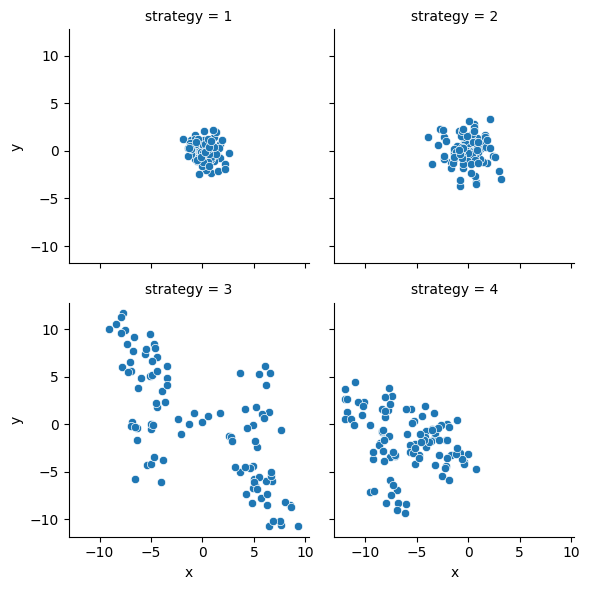

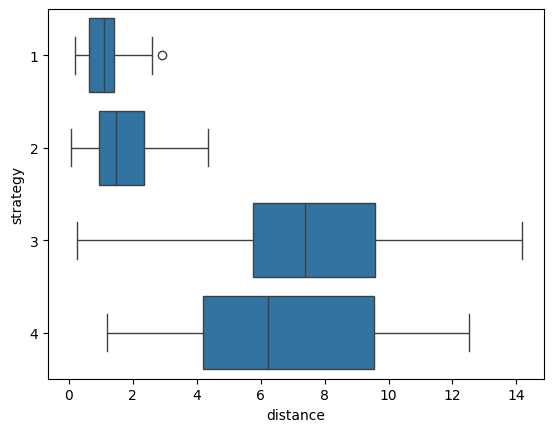

In [5]:
np.random.seed(1)
results = []
nrepeat = 100

# strategy 1
# funnel fixed
position = (0, 0)
for _ in range(nrepeat):
  dropped = funnel_drop(position)
  results.append(result(1, dropped))

# strategy 2
# position funnel to compensate for error relative to funnel position
position = np.array([0, 0])
for _ in range(nrepeat):
  dropped = funnel_drop(position)
  results.append(result(2, dropped))
  position = position - dropped

# strategy 3
# position funnel to compensate for error relative to target
position = np.array([0, 0])
for _ in range(nrepeat):
  dropped = funnel_drop(position)
  results.append(result(3, dropped))
  position = - dropped

# strategy 4
# position funnel to compensate for error relative to target
position = np.array([0, 0])
for _ in range(nrepeat):
  dropped = funnel_drop(position)
  results.append(result(4, dropped))
  position = dropped

results = pd.DataFrame(results)
g = sns.FacetGrid(results, col='strategy', col_wrap=2)
g.map(sns.scatterplot, 'x', 'y')
plt.show()
sns.boxplot(x='distance', y='strategy', data=results, orient='h')
#g = sns.FacetGrid(results, col='strategy')
#g.map(sns.boxplot, 'distance', order='strategy', orient='v')
plt.show()

# Exercise 3

In [6]:
from mistat.design import doe

np.random.seed(1) # set random seed for reproducibility
Factors = {
    'm': [30, 60],
    's': [0.005, 0.02],
    'v0': [0.002, 0.01],
    'k': [1_000, 5_000],
    'p0': [90_000, 110_000],
    't': [290, 296],
    't0': [340, 360],
}
Designs = {
    'Latin hypercube': doe.lhs(Factors, num_samples=50),
    'Latin hypercube (space filling)': doe.space_filling_lhs(Factors, num_samples=50),
    'Random k-means cluster': doe.random_k_means(Factors, num_samples=50),
    'Maximin reconstruction': doe.maximin(Factors, num_samples=50),
    'Halton sequence based': doe.halton(Factors, num_samples=50),
    'Uniform random matrix': doe.uniform_random(Factors, num_samples=50),
}

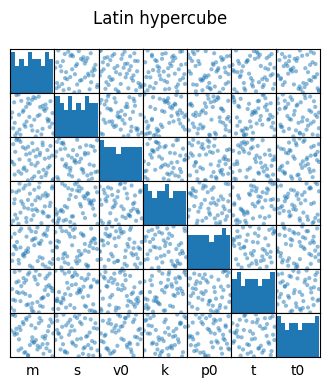

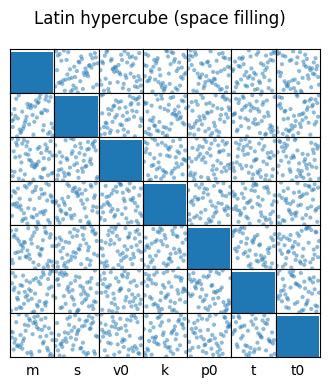

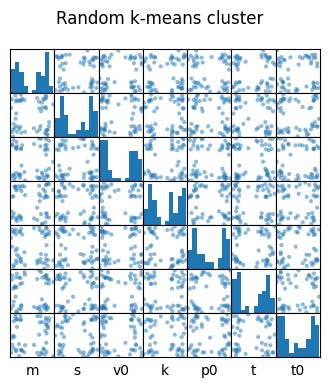

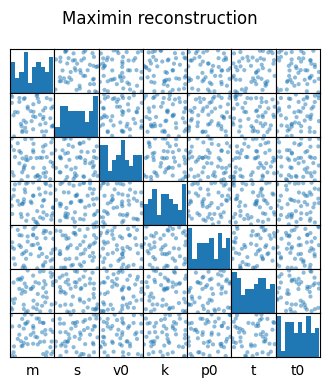

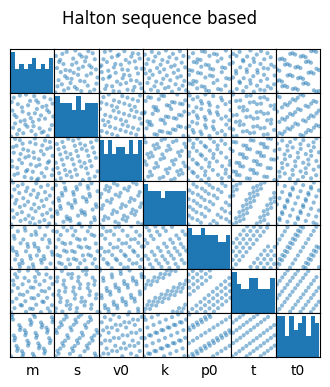

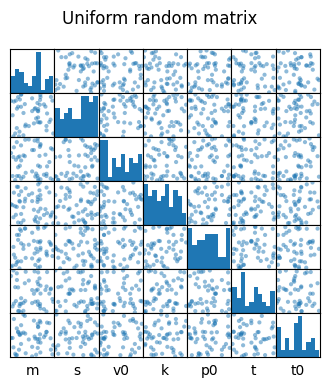

In [7]:
for method, design in Designs.items():
    sm = pd.plotting.scatter_matrix(design, figsize=[4, 4])
    # hide all axis labels in visualization
    for subaxis in sm:
        for ax in subaxis:
            ax.xaxis.set_ticks([])
            ax.yaxis.set_ticks([])
            ax.set_ylabel("")
    plt.suptitle(method)
    plt.show()

# Exercise 4

In [8]:
if lk:
    random.seed(1)
    np.random.seed(1)
    
    outcome = 'seconds'
    predictors = ['m', 's', 'v0', 'k', 'p0', 't', 't0']
    
    performance = []
    for method, Design in Designs.items():
        # randomize the design and run the piston simulator
        DesignRandomized = Design.sample(frac=1, random_state=1).reset_index(drop=True)
        simulator = mistat.PistonSimulator(parameter=DesignRandomized)
        result = simulator.simulate()
    
        # convert to X and y matrics to use with the 
        X = result[predictors].values
        y = result[outcome].values
    
        # run 5-fold cross-validation to determine MSE values
        # we collect the out-of-fold predictions to determine 
        # the MSE
        predicted = []
        actual = []
        for train_idx, test_idx in KFold(n_splits=5).split(result):
            model = lk.Kriging(y[train_idx], X[train_idx], 'gauss')
    
            # predict using the test set
            ypred = model.predict(X[test_idx], True, False, False)[0]
            # keep prediction results for performance metric calculation
            actual.extend(y[test_idx])
            predicted.extend(ypred)
    
        mse = mean_squared_error(actual, predicted)
        performance.append({
            'design': method,
            'mse': mse,
            'rmse': np.sqrt(mse),
        })

In [9]:
if lk:
    s = pd.DataFrame(performance).style.hide(axis='index')
    s

# Exercise 5

In [10]:
np.random.seed(1)

num_samples = 1000
Design = doe.uniform_random(Factors, num_samples=num_samples)

In [11]:
def evaluateDesign(Design, nrepeat=20):
  #Design = Design.loc[np.repeat(Design.index.values, nrepeat), :]
  #settings = {c: list(Design[c]) for c in Design.columns}
  #simulator = mistat.PistonSimulator(seed=1, **settings)
  simulator = mistat.PistonSimulator(parameter=Design, seed=1, n_replicate=nrepeat)
  result = simulator.simulate()
  result = mistat.simulationGroup(result, nrepeat)

  # next we aggregate the replicates and determine mean and 
  # standard deviation of each group.
  options = {p: 'mean' for p in ['m', 's', 'v0', 'k', 'p0', 't', 't0']}
  options['seconds'] = ['mean', 'std']
  result = result.groupby('group').aggregate(options)
  # convert multi-index to single index
  result.columns = [' '.join(col) if col[0] == 'seconds' else col[0]
                    for col in result.columns]
  return result
  
result = evaluateDesign(Design, nrepeat=30)

In [12]:
# determine rows with seconds around 0.02 and 
# identify row with smallest standard deviation
rows = [0.0195 < v < 0.0205 for v in result['seconds mean'].values]
target = result.loc[rows, :]
target = target.sort_values('seconds std')
target.head(3)

,m,s,v0,k,p0,t,t0,seconds mean,seconds std
group,,,,,,,,,
871,59.694778,0.018177,0.004087,1152.373331,109480.515301,293.342719,350.794200,0.020356,0.002469
331,46.278492,0.018261,0.004200,1432.269941,93825.441035,292.322277,357.081196,0.020009,0.002751
947,37.548930,0.012126,0.003148,1280.072660,105859.307614,291.076845,342.524145,0.019582,0.003092


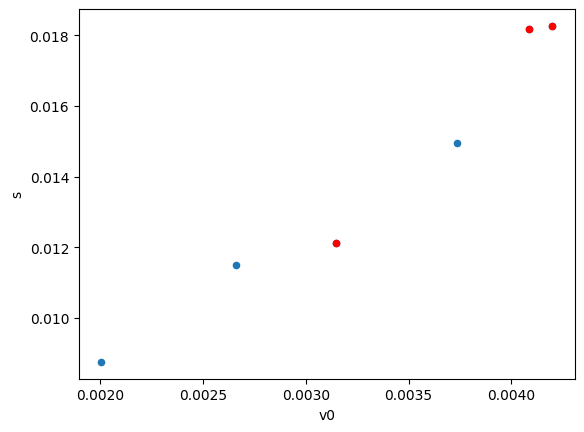

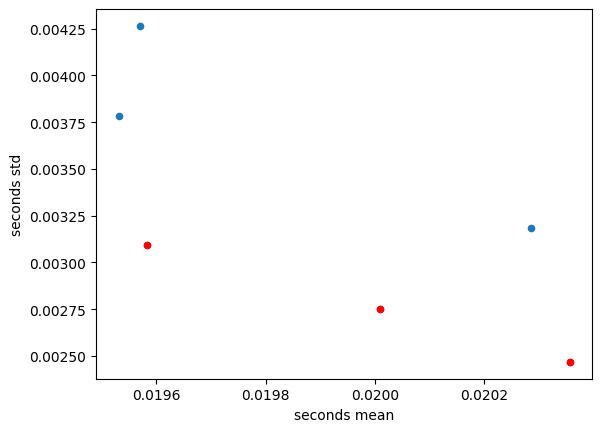

In [13]:
ax = target.plot.scatter(x='v0', y='s')
target.head(3).plot.scatter(x='v0', y='s', ax=ax, color='red')
ax = target.plot.scatter(x='seconds mean', y='seconds std')
target.head(3).plot.scatter(x='seconds mean', y='seconds std', ax=ax, color='red')
plt.show()

# Exercise 6

In [14]:
np.random.seed(1)

num_samples = 1000
Design = doe.lhs(Factors, num_samples=num_samples, random_state=1)
result = evaluateDesign(Design, nrepeat=30)

# determine rows with seconds around 0.02 and 
# identify row with smallest standard deviation
rows = [0.0195 < v < 0.0205 for v in result['seconds mean'].values]
target = result.loc[rows, :]
target = target.sort_values('seconds std')
target.head(3)

,m,s,v0,k,p0,t,t0,seconds mean,seconds std
group,,,,,,,,,
368,33.166208,0.016760,0.003876,2998.808445,96800.530567,291.237264,341.684282,0.020127,0.001956
940,39.401808,0.019256,0.004388,3024.658005,97630.295509,295.393884,351.093709,0.020001,0.002313
150,33.434638,0.019884,0.004685,1401.296554,92707.973181,292.463943,353.536655,0.020030,0.002467


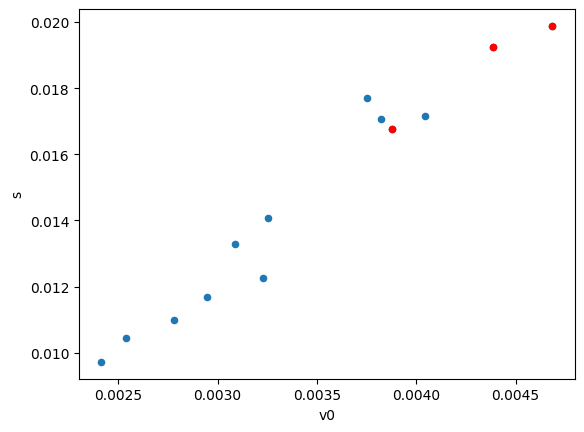

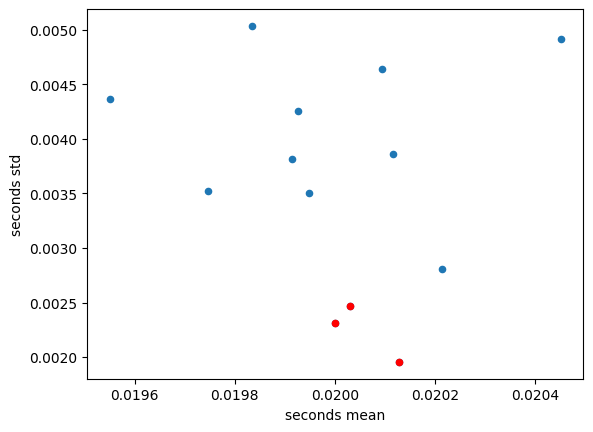

In [15]:
ax = target.plot.scatter(x='v0', y='s')
target.head(3).plot.scatter(x='v0', y='s', ax=ax, color='red')
ax = target.plot.scatter(x='seconds mean', y='seconds std')
target.head(3).plot.scatter(x='seconds mean', y='seconds std', ax=ax, color='red')
plt.show()